# Assignment 2: Analysis on Simulacrum data

## 1. Introduction

### About Simulacrum

The Simulacrum imitates some of the data held securely by the Public Health England’s National Cancer Registration and Analysis Service. The Simulacrum has 8 tabular datasets, which contain data on 1,322,100 synthetic patients and 1,402,817 synthetic tumours. It also involves data about Systemic Anti-Cancer Therapy (SACT).

### About this report

This report mainly focuses on the first two datasets in Simulacrum, 'SIM_AV_PATIENT' and 'SIM_AV_TUMOUR.' The two tables consist of the patient and tumour registration data and are connected by patients' ID numbers.
Analysis and explorations in this report involve the following subjects:
- Patient demographic information
- Patient death causes
- Classification of neoplasms
- Associations between death rates between different groups of factors
- ...

## 2. Data processing and Analysis

### 2.1 Basic Configurations

In [1]:
# Import necessary modules for data analysis and visualisation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re

In [2]:
sns.set(style='whitegrid',palette='muted',color_codes=True)

### 2.2 Import Data

Two CSV files are required for this report:

- sim_av_patient.csv
- sim_av_tumour.csv

 The `SIM_AV_PATIENT` table holds the demographic and clinical information and of the patient. The `SIM_AV_TUMOUR` table contains most of the detailed information regarding staging and pathology of the tumour. The two tables are connected by `PATIENTID`, an overlapped column in both tables.

In [3]:
# Patient registration data
patient = pd.read_csv('./data/sim_av_patient.csv', delimiter=',')

# Tumour registration data
tumour = pd.read_csv('./data/sim_av_tumour.csv', delimiter=',')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (5,6,8,9,17,18,20,22,26,32) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Another two CSV files are also required:

- icd_codes.csv
- icd_codes_3char.csv

These files contain 4-digit and 3-digit **ICD-10 codes** and descriptions, namely the 10th revision of the International Statistical Classification of Diseases and Related Health Problems. ICD-10 codes are for diseases, signs and symptoms, abnormal findings, complaints, social circumstances, and external causes of injury or diseases. ICD-10 codes are helpful to classify types of neoplasms and death causes.

In [4]:
# ICD-10 codes and descriptions
icd_codes = pd.read_csv('icd_codes.csv', delimiter=",", header=None, names=['Category Code', 'Diagnosis Code', 'Full Code', 'Abbreviated Description', 'Full Description', 'Category Title'])

# 3-digit ICD-10 codes and descriptions
icd_codes_3char = pd.read_csv('icd_codes_3char.csv', delimiter=",", header=None, names=['Code', 'Description'])

### 2.3 Data Description

#### SIM_AV_PATIENT

In [5]:
# Display the first 5 entries
patient.head()

,PATIENTID,SEX,LINKNUMBER,ETHNICITY,DEATHCAUSECODE_1A,DEATHCAUSECODE_1B,DEATHCAUSECODE_1C,DEATHCAUSECODE_2,DEATHCAUSECODE_UNDERLYING,DEATHLOCATIONCODE,NEWVITALSTATUS,VITALSTATUSDATE
0,10000001,2,810000001,A,NaN,NaN,NaN,NaN,NaN,NaN,A,2017-01-17
1,10000002,2,810000002,Z,NaN,NaN,NaN,NaN,NaN,NaN,A,2017-01-14
2,10000003,1,810000003,A,NaN,NaN,NaN,NaN,NaN,NaN,A,2017-01-17
3,10000004,1,810000004,A,NaN,NaN,NaN,NaN,NaN,NaN,A,2017-01-13
4,10000005,2,810000005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A,2017-01-16


This table has 1,322,100 entries and 12 columns. The columns are:

- **Patient ID**: ID numbers of patients, which allow linkeage to tumour registration data.
- **Sex**: Sex of patients, 1 for Male and 2 for Female.
- **Link Number**: Numbers allow linkeage to SACT data.
- **Ethnicity**: Ethnic information of patients in [NHS ethnic category code](https://www.datadictionary.nhs.uk/data_dictionary/attributes/e/end/ethnic_category_code_de.asp)
- **Death Cause Code**: Causes of death of each patient in 5 columns, coded with 1A, 1B, 1C, 2 and Underlying.
- **Death Location Code**: Code of the location where the patient died.
- **Vital Status**: Whether the patient is alive or deceased.
- **Vital Status Date**: Date of the vital status of the patient.

You can find more information about columns in this table with [CAS Explorer](https://www.cancerdata.nhs.uk/explorer/cas_columns).


In [6]:
# Display information about the dataset
patient.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1322100 entries, 0 to 1322099
Data columns (total 12 columns):
PATIENTID                    1322100 non-null int64
SEX                          1322100 non-null int64
LINKNUMBER                   1322100 non-null int64
ETHNICITY                    1192249 non-null object
DEATHCAUSECODE_1A            330280 non-null object
DEATHCAUSECODE_1B            98085 non-null object
DEATHCAUSECODE_1C            18106 non-null object
DEATHCAUSECODE_2             141982 non-null object
DEATHCAUSECODE_UNDERLYING    327910 non-null object
DEATHLOCATIONCODE            330381 non-null object
NEWVITALSTATUS               1322100 non-null object
VITALSTATUSDATE              1322100 non-null object
dtypes: int64(3), object(9)
memory usage: 121.0+ MB


#### SIM_AV_TUMOUR

In [7]:
# Display the first 5 entries
tumour.head()

,TUMOURID,PATIENTID,DIAGNOSISDATEBEST,SITE_ICD10_O2,SITE_ICD10_O2_3CHAR,MORPH_ICD10_O2,BEHAVIOUR_ICD10_O2,T_BEST,N_BEST,M_BEST,...,PERFORMANCESTATUS,CNS,ACE27,GLEASON_PRIMARY,GLEASON_SECONDARY,GLEASON_TERTIARY,GLEASON_COMBINED,DATE_FIRST_SURGERY,LATERALITY,QUINTILE_2015
0,10000001,10000001,2015-11-06,C443,C44,8090,3,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-11-06,L,3
1,10000002,10000002,2015-10-06,C449,C44,8090,3,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-10-06,8,2
2,10000003,10000003,2013-01-30,C449,C44,8090,3,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,1 - least deprived
3,10000004,10000004,2015-09-15,C449,C44,8090,3,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,2
4,10000005,10000005,2014-11-01,C449,C44,8090,3,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-11-01,8,2


This table has 1,402,817 entries and 34 columns. The columns describe the following information about registered tumours:
- **ID Numbers**
- **Site**
- **Morphology**
- **Behaviour**
- **Staging in TNM System**
- **Gleason score**
- ...

In [8]:
# Display information about the dataset
tumour.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1402817 entries, 0 to 1402816
Data columns (total 34 columns):
TUMOURID                    1402817 non-null int64
PATIENTID                   1402817 non-null int64
DIAGNOSISDATEBEST           1402817 non-null object
SITE_ICD10_O2               1402303 non-null object
SITE_ICD10_O2_3CHAR         1402356 non-null object
MORPH_ICD10_O2              1402304 non-null object
BEHAVIOUR_ICD10_O2          1402410 non-null object
T_BEST                      653053 non-null object
N_BEST                      546397 non-null object
M_BEST                      535682 non-null object
STAGE_BEST                  1402801 non-null object
STAGE_BEST_SYSTEM           671840 non-null float64
GRADE                       1340030 non-null object
AGE                         1402817 non-null int64
SEX                         1402817 non-null int64
CREG_CODE                   1402817 non-null object
LINKNUMBER                  1402817 non-null int64
SCREENINGST

### 2.4 Data Cleaning

#### SIM_AV_PATIENT

In [9]:
# patient.fillna('', inplace=True)
patient.head()

,PATIENTID,SEX,LINKNUMBER,ETHNICITY,DEATHCAUSECODE_1A,DEATHCAUSECODE_1B,DEATHCAUSECODE_1C,DEATHCAUSECODE_2,DEATHCAUSECODE_UNDERLYING,DEATHLOCATIONCODE,NEWVITALSTATUS,VITALSTATUSDATE
0,10000001,2,810000001,A,NaN,NaN,NaN,NaN,NaN,NaN,A,2017-01-17
1,10000002,2,810000002,Z,NaN,NaN,NaN,NaN,NaN,NaN,A,2017-01-14
2,10000003,1,810000003,A,NaN,NaN,NaN,NaN,NaN,NaN,A,2017-01-17
3,10000004,1,810000004,A,NaN,NaN,NaN,NaN,NaN,NaN,A,2017-01-13
4,10000005,2,810000005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A,2017-01-16


##### I. Inconsistent delimiters in death cause code columns
There are several columns in this table which represent death causes of the patients. These death causes are recorded with ICD-10 codes and if a patient died because of multiple factors, the codes are separated by commas.

However, in some of the rows, the delimiter is space(' '), semicolon(';'), or full-stop('.') rather than comma, which should be fixed.

In [10]:
# Define a function which is used to turn all other delimiters in death cause code columns with commas.
def to_comma(code):
    """
    This function replaces all the delimiters in the given code to commas.
    :param group: string
    :return: string
    """
    if code != '':
        if code.count('.') > 0 and any(x.isdigit() for x in code): # Replace full-stops with commas.
            code = code.replace('.', ',')
            return code
        elif code.count(';') > 0 and any(x.isdigit() for x in code):  # Replace semicolons with commas.
            code = code.replace(';', ',')
            return code
        elif code.count(' ') > 0 and any(x.isdigit() for x in code):   # Replace space with commas.
            code = code.replace(' ', ',')
            return code
        else:
            return code
    else:
        return code
    
# Apply the function to all the death cause code columns with `Series.map()`.
patient['DEATHCAUSECODE_1A'] = patient['DEATHCAUSECODE_1A'].map(to_comma)
patient['DEATHCAUSECODE_1B'] = patient['DEATHCAUSECODE_1B'].map(to_comma)
patient['DEATHCAUSECODE_1C'] = patient['DEATHCAUSECODE_1C'].map(to_comma)
patient['DEATHCAUSECODE_2'] = patient['DEATHCAUSECODE_2'].map(to_comma)
patient['DEATHCAUSECODE_UNDERLYING'] = patient['DEATHCAUSECODE_UNDERLYING'].map(to_comma)

AttributeError: 'float' object has no attribute 'count'

After converting the inconsistent delimiters, all the values should match ICD-10 codes, which means the strings or their substrings splited by commas should start with a letter (A-Y) and contain at least 2 digits. 

In [ ]:
death_causes = {} # Init a dict to store all the death cause codes and how many times.

 # This regular expression is to match ICD-10 codes like strings, e.g. 'R66' or 'R668'
icd_pattern = '^[A-Z]{1}\d{2,}$'

# Define a function to split multiple codes and calculate the numbers of each code.
def calculate_death_causes(code):
    """
    This function calculates the numbers of the given death cause.
    :param group: string
    :return: integer
    """
    if code != '':
        for i in code.split(','):
            if i.strip() not in death_causes and i != '' and re.match(icd_pattern, i) != None:
                death_causes[i.strip()] = 1  # If the death code is not in the dict, put it in and set its number to 1.
            elif i != '' and re.match(icd_pattern, i) != None:
                death_causes[i.strip()] += 1 # Otherwise, add 1 to its number.
    else:
        pass

# Apply this function to all the death cause code columns.
patient['DEATHCAUSECODE_1A'].map(calculate_death_causes)
patient['DEATHCAUSECODE_1B'].map(calculate_death_causes)
patient['DEATHCAUSECODE_1C'].map(calculate_death_causes)
patient['DEATHCAUSECODE_2'].map(calculate_death_causes)
patient['DEATHCAUSECODE_UNDERLYING'].map(calculate_death_causes)

# Turn the dict into a Pandas Series Object.
death_causes_series = pd.Series(death_causes)

In [ ]:
# dc_not_coded = death_causes_series[np.where(death_causes_series.index.map(len) >= 5)[0]]
# dc_not_coded.index
# [re.match(icd_pattern, code) for code in death_causes_series.index]

##### II. Data format conversion and errors on vital status date

#### SIM_AV_TUMOUR


##### I. Fill the blanks

In [11]:
tumour.fillna('', inplace=True)

 ##### II. Data format conversion and errors
 Similarly, there are two columns in this table involves dates, which should be converted.

In [12]:
tumour['DIAGNOSISDATEBEST'] = pd.to_datetime(tumour['DIAGNOSISDATEBEST']) # Convert diagnosis dates into time stamp
tumour['DATE_FIRST_SURGERY'] = pd.to_datetime(tumour['DATE_FIRST_SURGERY']) # Convert dates of first surgery into time stamp

##### III. Mixed types in several columns

As can be seen in the section 'Import Data', multiple columns in this table contain values in different data types.

### 2.5 Data Merging

Both tables are cleaned and ready to merge. The two datasets are linked by a shared column 'PATIENTID', where the patients' ID numbers are recorded.

The new, merged dataset is called `merged_av_data`, it takes intersection of keys from both frames and the merge key is unique in right dataset.

In [13]:
merged_av_data = tumour.merge(patient, on='PATIENTID', how='inner', validate="many_to_one")

In [14]:
# Set the 'PATIENTID' and 'TUMOURID' columns as the index because one patient can get manifold cancers.
merged_av_data.set_index(['PATIENTID', 'TUMOURID'], inplace=True)

### 2.6 Data Analysis

#### 2.6.1 Demographic Information

##### Sex and Ethnicity Distribution

In [17]:
# Group the data by sex and ethnicity to see the demographic information of patients.
group_sex_ethnicity = patient.groupby(['SEX', 'ETHNICITY' ]).count()

# The proportion of ethnic groups among male patients
m_ethnicity = group_sex_ethnicity['PATIENTID'][0:20]
m_ethnicity_codes = [x[1] for x in m_ethnicity.index]
ethnicity_names = ['', '', 'British', 'Irish', 'Any other White background', 'White and Black Caribbean', 'White and Black African', 'White and Asian', 'Any other mixed background', 'Indian', 'Pakistani', 'Bangladeshi', 'Any other Asian background', 'Caribbean', 'African', 'Any other black background', 'Chinese', 'Any other ethnic group', '', 'Not stated']
m_labels = list(zip(m_ethnicity_codes, ethnicity_names))

# # The proportion of ethnic groups among non-British male patients
m_non_british = m_ethnicity.drop(labels=(1, 'A'))
m_non_british_labels = list(zip(m_ethnicity_codes, ethnicity_names))
m_non_british_labels.remove(('A', 'British'))

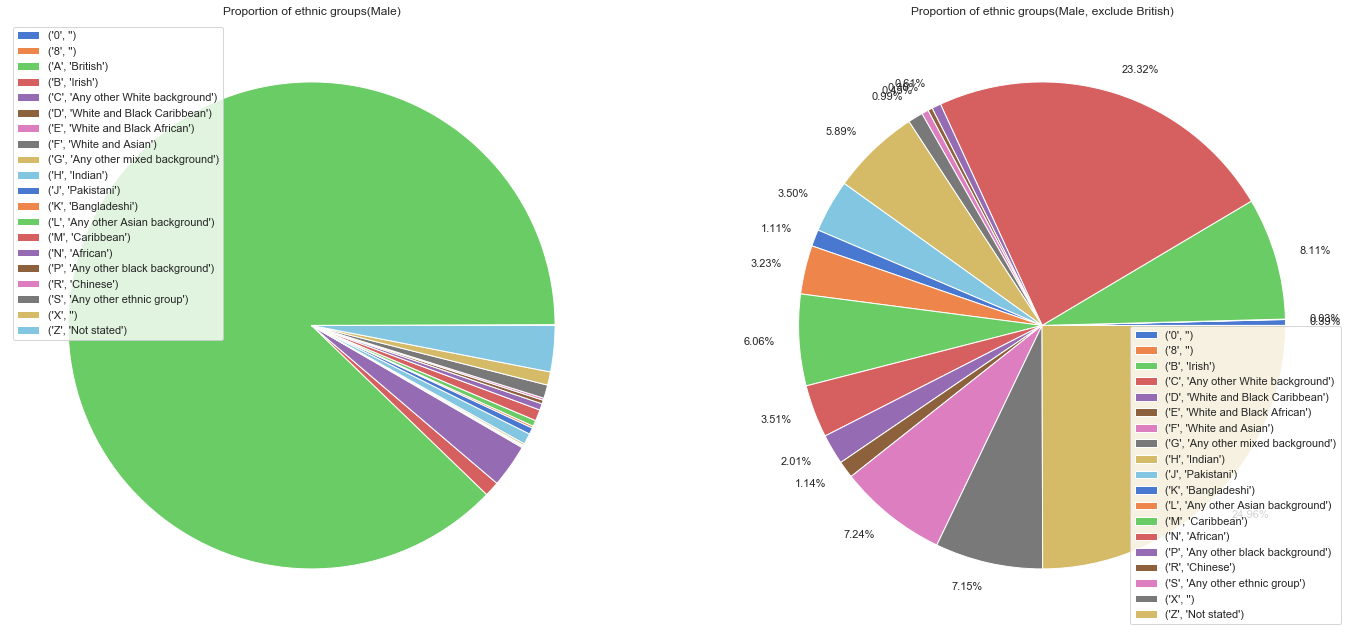

In [18]:
# Visualise the proportion in two pie charts
fig1, ax1 = plt.subplots(1, 2, figsize=(24, 24))
ax1[0].pie(m_ethnicity, textprops={'fontsize': 8})
ax1[1].pie(m_non_british, labels=['%.2f%%' % (x / m_non_british.sum() * 100) for x in m_non_british.values])
ax1[0].set_title('Proportion of ethnic groups(Male)')
ax1[1].set_title('Proportion of ethnic groups(Male, exclude British)')
ax1[0].legend(m_labels)
ax1[1].legend(m_non_british_labels, loc='lower right')


In [19]:
# The proportion of ethnic groups among female patients
fm_ethnicity = group_sex_ethnicity['PATIENTID'][20:40]
fm_ethnicity_codes = [x[1] for x in fm_ethnicity.index]
fm_labels = list(zip(fm_ethnicity_codes, ethnicity_names))

# The proportion of ethnic groups among non-british female patients
fm_non_british = fm_ethnicity.drop(labels=(2, 'A'))
fm_non_british_labels = list(zip(fm_ethnicity_codes, ethnicity_names))
fm_non_british_labels.remove(('A', 'British'))

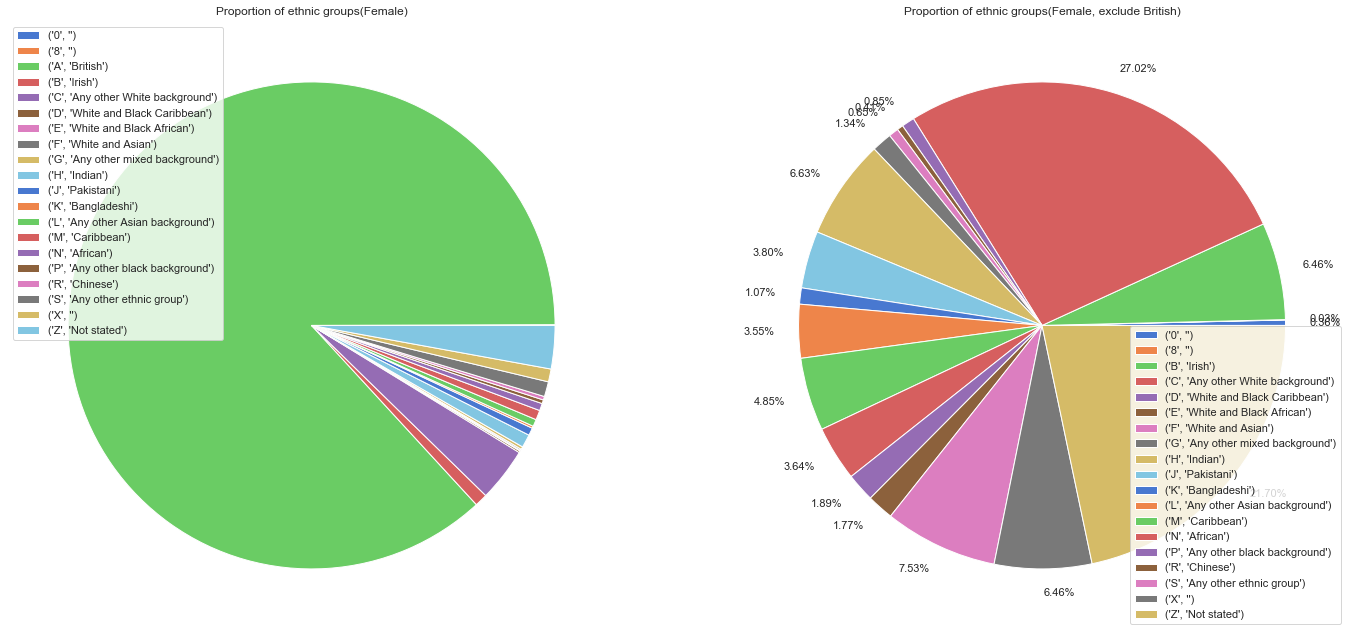

In [21]:
# Visualise the proportion in two pie charts
fig2, ax2 = plt.subplots(1, 2, figsize=(24, 24))
ax2[0].pie(fm_ethnicity)
ax2[1].pie(fm_non_british, labels=['%.2f%%' % (x / fm_non_british.sum() * 100) for x in fm_non_british.values])
ax2[0].set_title('Proportion of ethnic groups(Female)')
ax2[1].set_title('Proportion of ethnic groups(Female, exclude British)')
ax2[0].legend(fm_labels)
ax2[1].legend(fm_non_british_labels)

##### Age Distribution

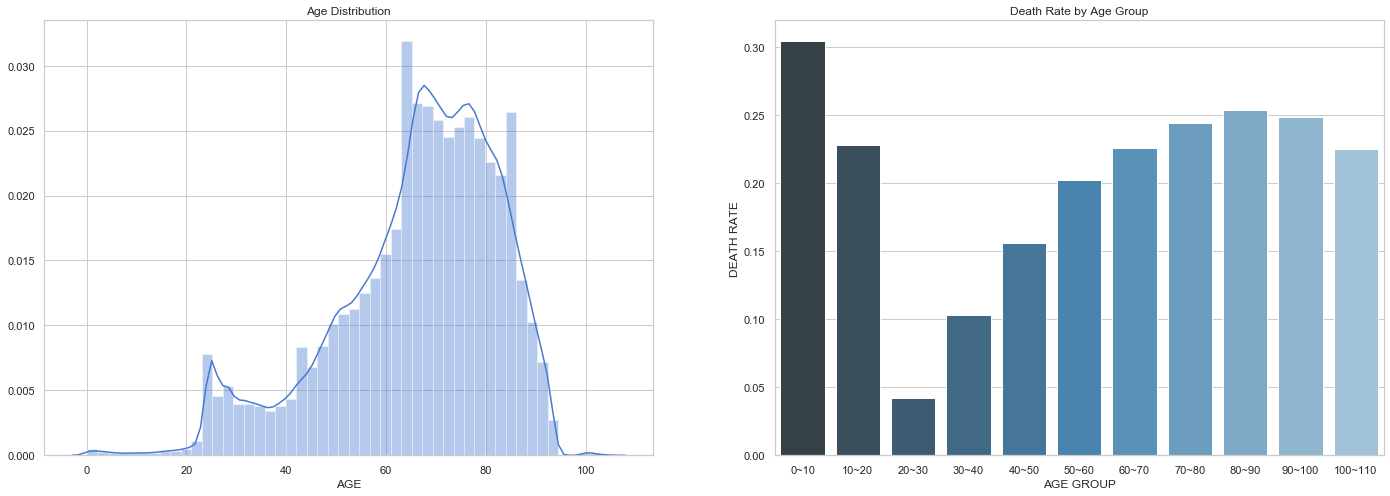

In [22]:
f, axes = plt.subplots(1, 2, figsize=(24, 8), dpi=72)
age_distribution = sns.distplot(merged_av_data['AGE'], ax=axes[0]) # Plot a histogram to show the distribution of age groups
age_distribution.set_title('Age Distribution') # Set title for the group

def calculate_death_rate(group):
    """
    This function calculates the death rate in the given group of ages.
    :param group: list
    :return: float
    """
    g = merged_av_data.loc[(merged_av_data['AGE'] > group[0]) & (merged_av_data['AGE'] <= group[1]), :].groupby('NEWVITALSTATUS').count()
    death_rate = g.iloc[g.index.get_level_values('NEWVITALSTATUS') == 'D'].sum().max() / merged_av_data.loc[(merged_av_data['AGE'] > group[0]) & (merged_av_data['AGE'] <= group[1]), :].shape[0]
    return death_rate

age_groups = np.array([[x*10, (x+1)*10] for x in range(11)])

death_rate_by_age_group = pd.DataFrame(data={'AGE GROUP': [str(group[0]) + '~' + str(group[1]) for group in age_groups], 'DEATH RATE': [calculate_death_rate(group) for group in age_groups]})

ax_death_by_age = sns.barplot(x='AGE GROUP', y='DEATH RATE', data=death_rate_by_age_group, palette='Blues_d', orient='H', ax=axes[1])
ax_death_by_age.set_title('Death Rate by Age Group')
plt.xlabel = [x for x in range(10)]

#### 2.6.2 Classification of neoplasms and death rates

In [24]:
def match_neoplasms_3CHAR(site_code_3CHAR):
    """
    This function matches the given 3-digit code with description of a certain type of neoplasms according to ICD-10 codes.
    :param site_code_3CHAR: string
    :return: string
    """
    if site_code_3CHAR != "":
        return icd_codes_3char.loc[icd_codes_3char['Code'] == [re.search(site_code_3CHAR, icd_code).string for icd_code in icd_codes_3char['Code'].values if re.search(site_code_3CHAR, icd_code) != None][0], 'Description'].values[0]
    
def death_rate_by_site_3CHAR(site_code_3CHAR):
    """
    This function calculates the death rate of the given neoplasm.
    :param site_code_3CHAR: string
    :return: float
    """
    if site_code_3CHAR != "":
        g = merged_av_data[merged_av_data['SITE_ICD10_O2_3CHAR'] == site_code_3CHAR].groupby('NEWVITALSTATUS').count()
        death_rate = g.iloc[g.index.get_level_values('NEWVITALSTATUS') == 'D'].sum().max() / g.iloc[:, :].sum().max()
        return death_rate

types_of_cancer_3CHAR = pd.DataFrame({
    'Code': merged_av_data['SITE_ICD10_O2_3CHAR'].value_counts().index,
    'Description': [match_neoplasms_3CHAR(x) for x in list(merged_av_data['SITE_ICD10_O2_3CHAR'].value_counts().index.to_numpy())],
    'Amount': merged_av_data['SITE_ICD10_O2_3CHAR'].value_counts().values,
    'Death Rate': [death_rate_by_site_3CHAR(x) for x in list(merged_av_data['SITE_ICD10_O2_3CHAR'].value_counts().index.to_numpy())]
})

types_of_cancer_3CHAR.sort_values('Code').sort_values('Death Rate', ascending=True).head()

,Code,Description,Amount,Death Rate
4,D06,Carcinoma in situ of cervix uteri,76678,0.001500
14,D05,Carcinoma in situ of breast,19777,0.013905
36,C62,Malignant neoplasm of testis,5807,0.015499
29,D07,Carcinoma in situ of other and unspecified gen...,6931,0.025393
16,D03,Melanoma in situ,17123,0.029142


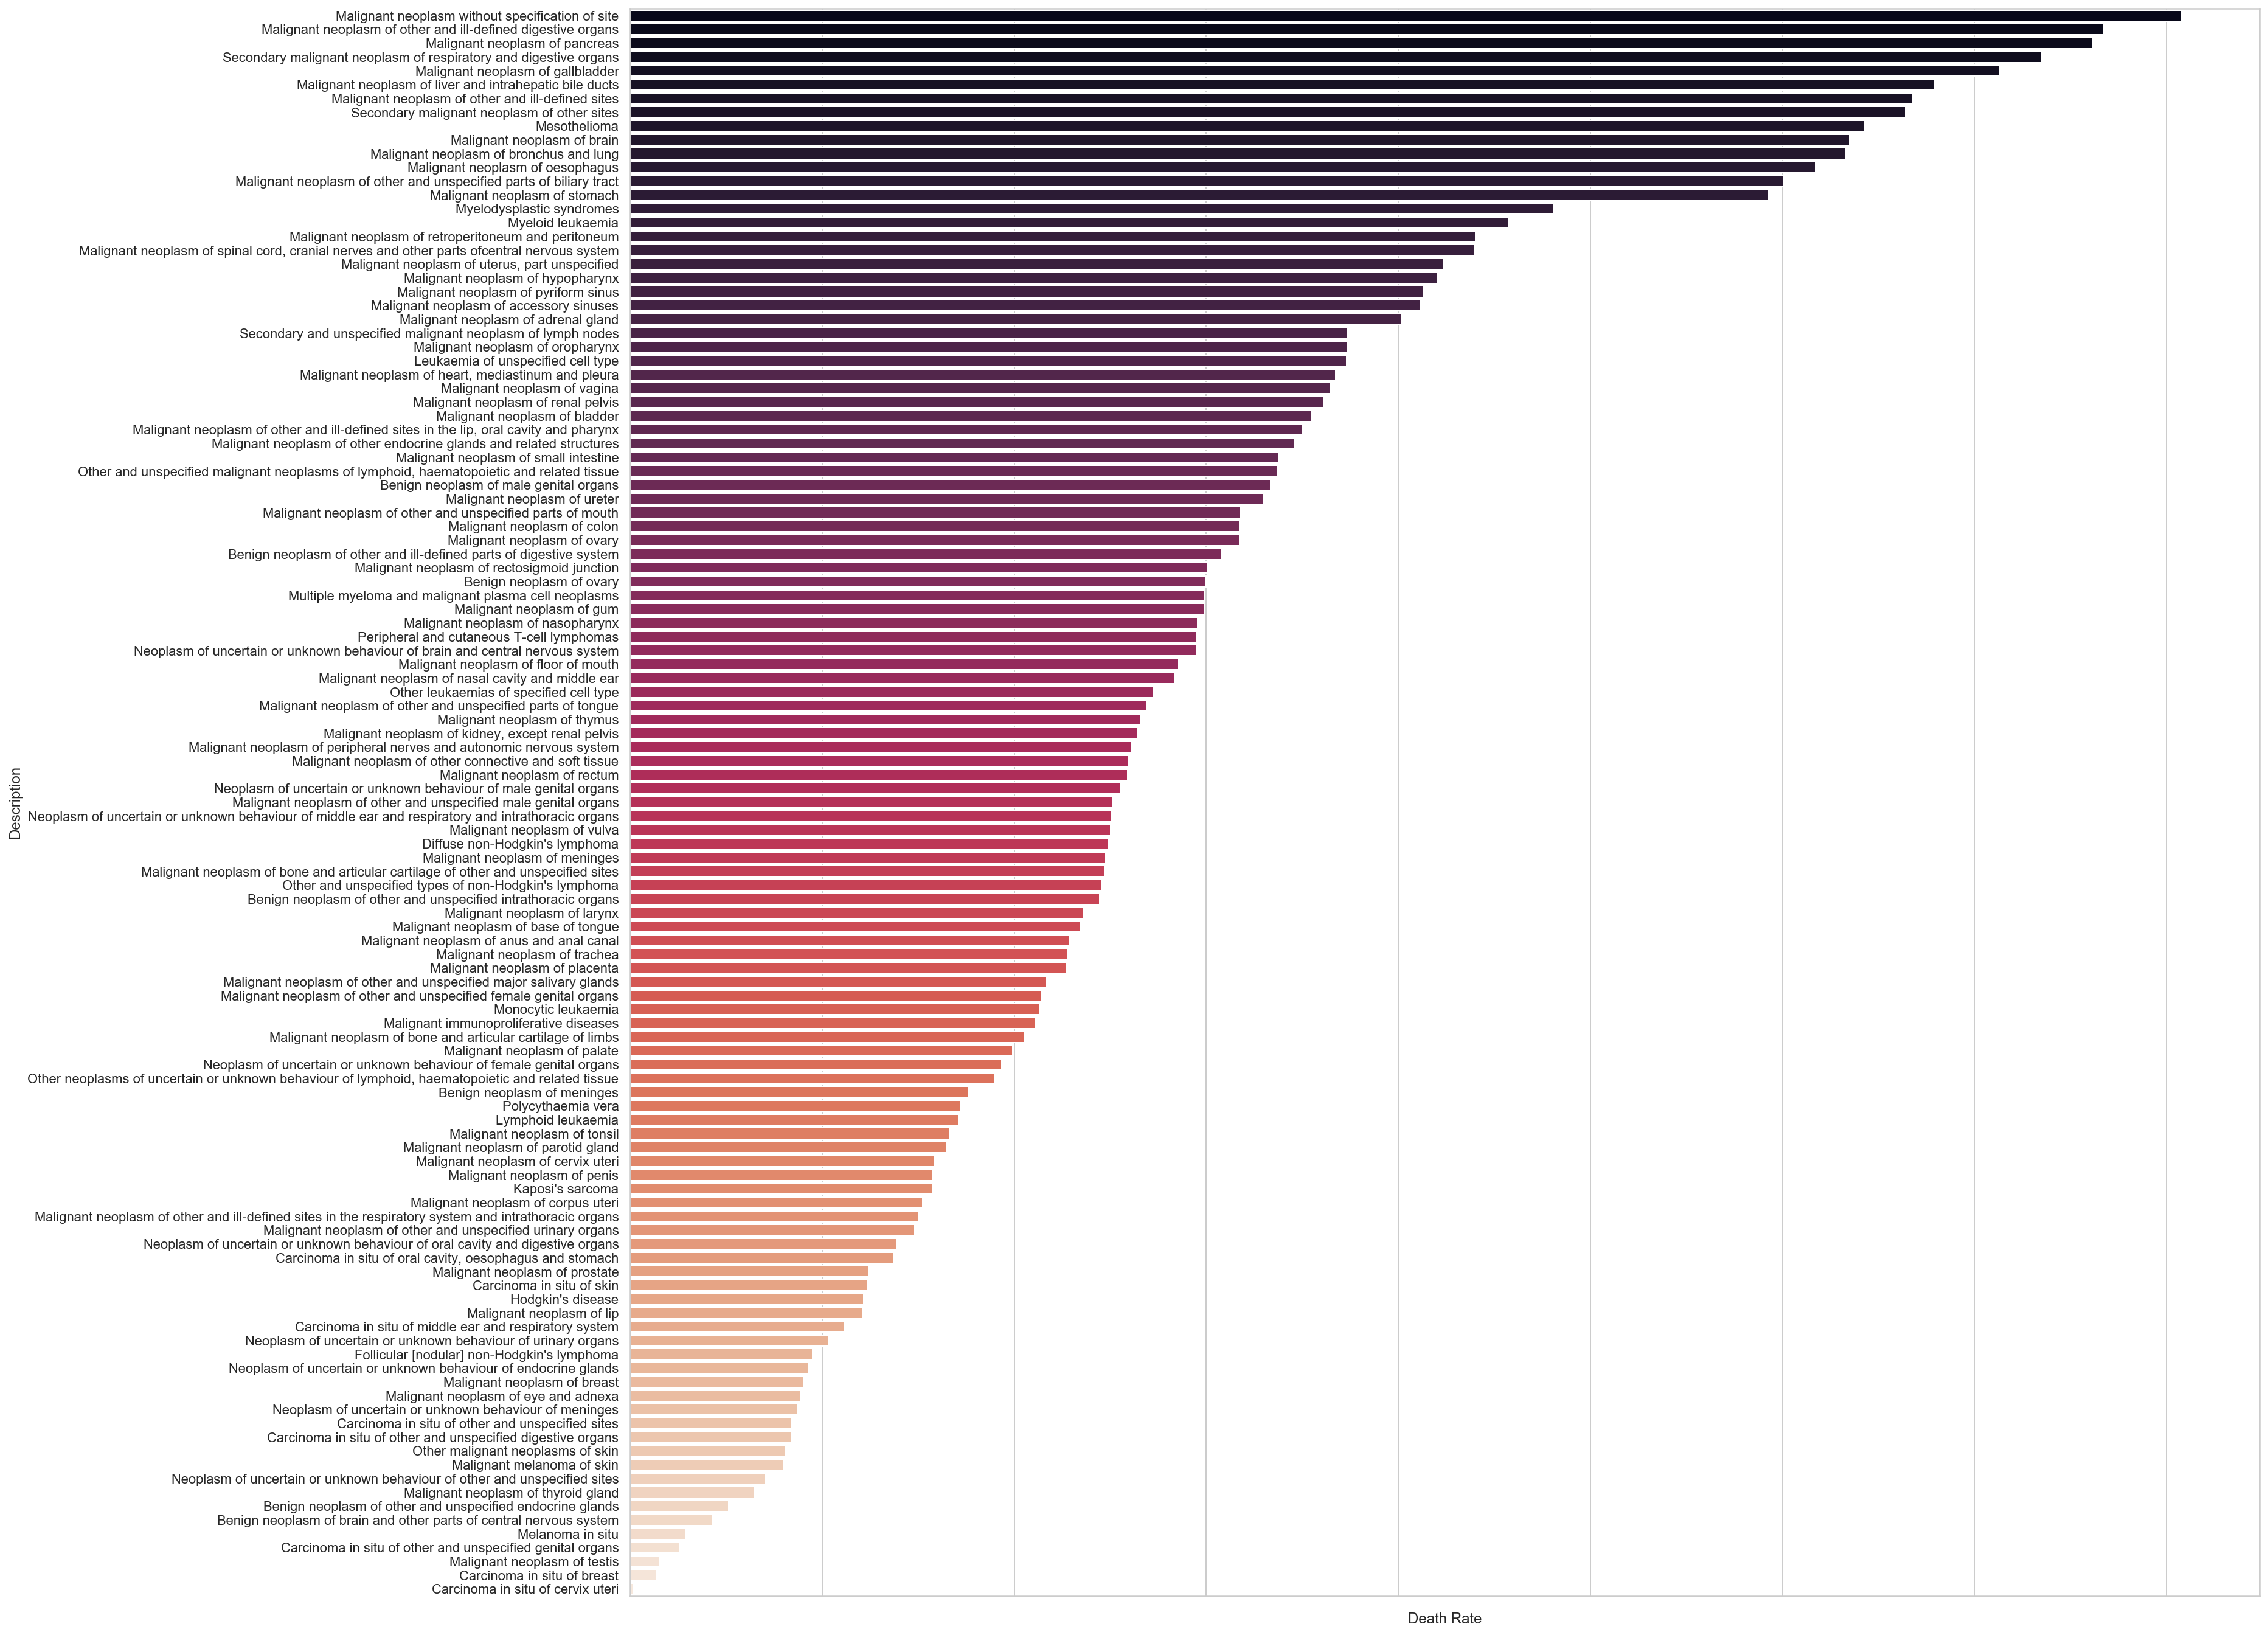

In [148]:
# Display death rates of each type of neoplasms in a barplot.
f1, axes1 = plt.subplots(1, 1, figsize=(24, 24), dpi=144)
types_of_neoplasms = sns.barplot(data=types_of_cancer_3CHAR.sort_values('Death Rate', ascending=False), x='Death Rate', y='Description', ax=axes1, palette='rocket')
axes1.set_xticklabels(axes1.get_xticklabels(), rotation=90)

# Show the plot
plt.show()

In [141]:
def calculate_site_by_sex(site_code_3CHAR):
    """
    This function calculates the death rate of the given neoplasm.
    :param site_code_3CHAR: string
    :return: float
    """
    if type(site_code_3CHAR) == str and site_code_3CHAR != '':
        site_in_male = merged_av_data[(merged_av_data['SITE_ICD10_O2_3CHAR'] == site_code_3CHAR) & (merged_av_data['SEX_x'] == 1)].shape[0]
        site_in_female = merged_av_data[(merged_av_data['SITE_ICD10_O2_3CHAR'] == site_code_3CHAR) & (merged_av_data['SEX_x'] == 2)].shape[0]
        return [site_in_male, site_in_female]
    else:
        return [0, 0]
    
amount_by_sex = pd.DataFrame({
    'Male': [x[0] for x in types_of_cancer_3CHAR['Code'].map(calculate_site_by_sex).values],
    'Female': [x[1] for x in types_of_cancer_3CHAR['Code'].map(calculate_site_by_sex).values]});

types_of_cancer_3CHAR = types_of_cancer_3CHAR.join(amount_by_sex)

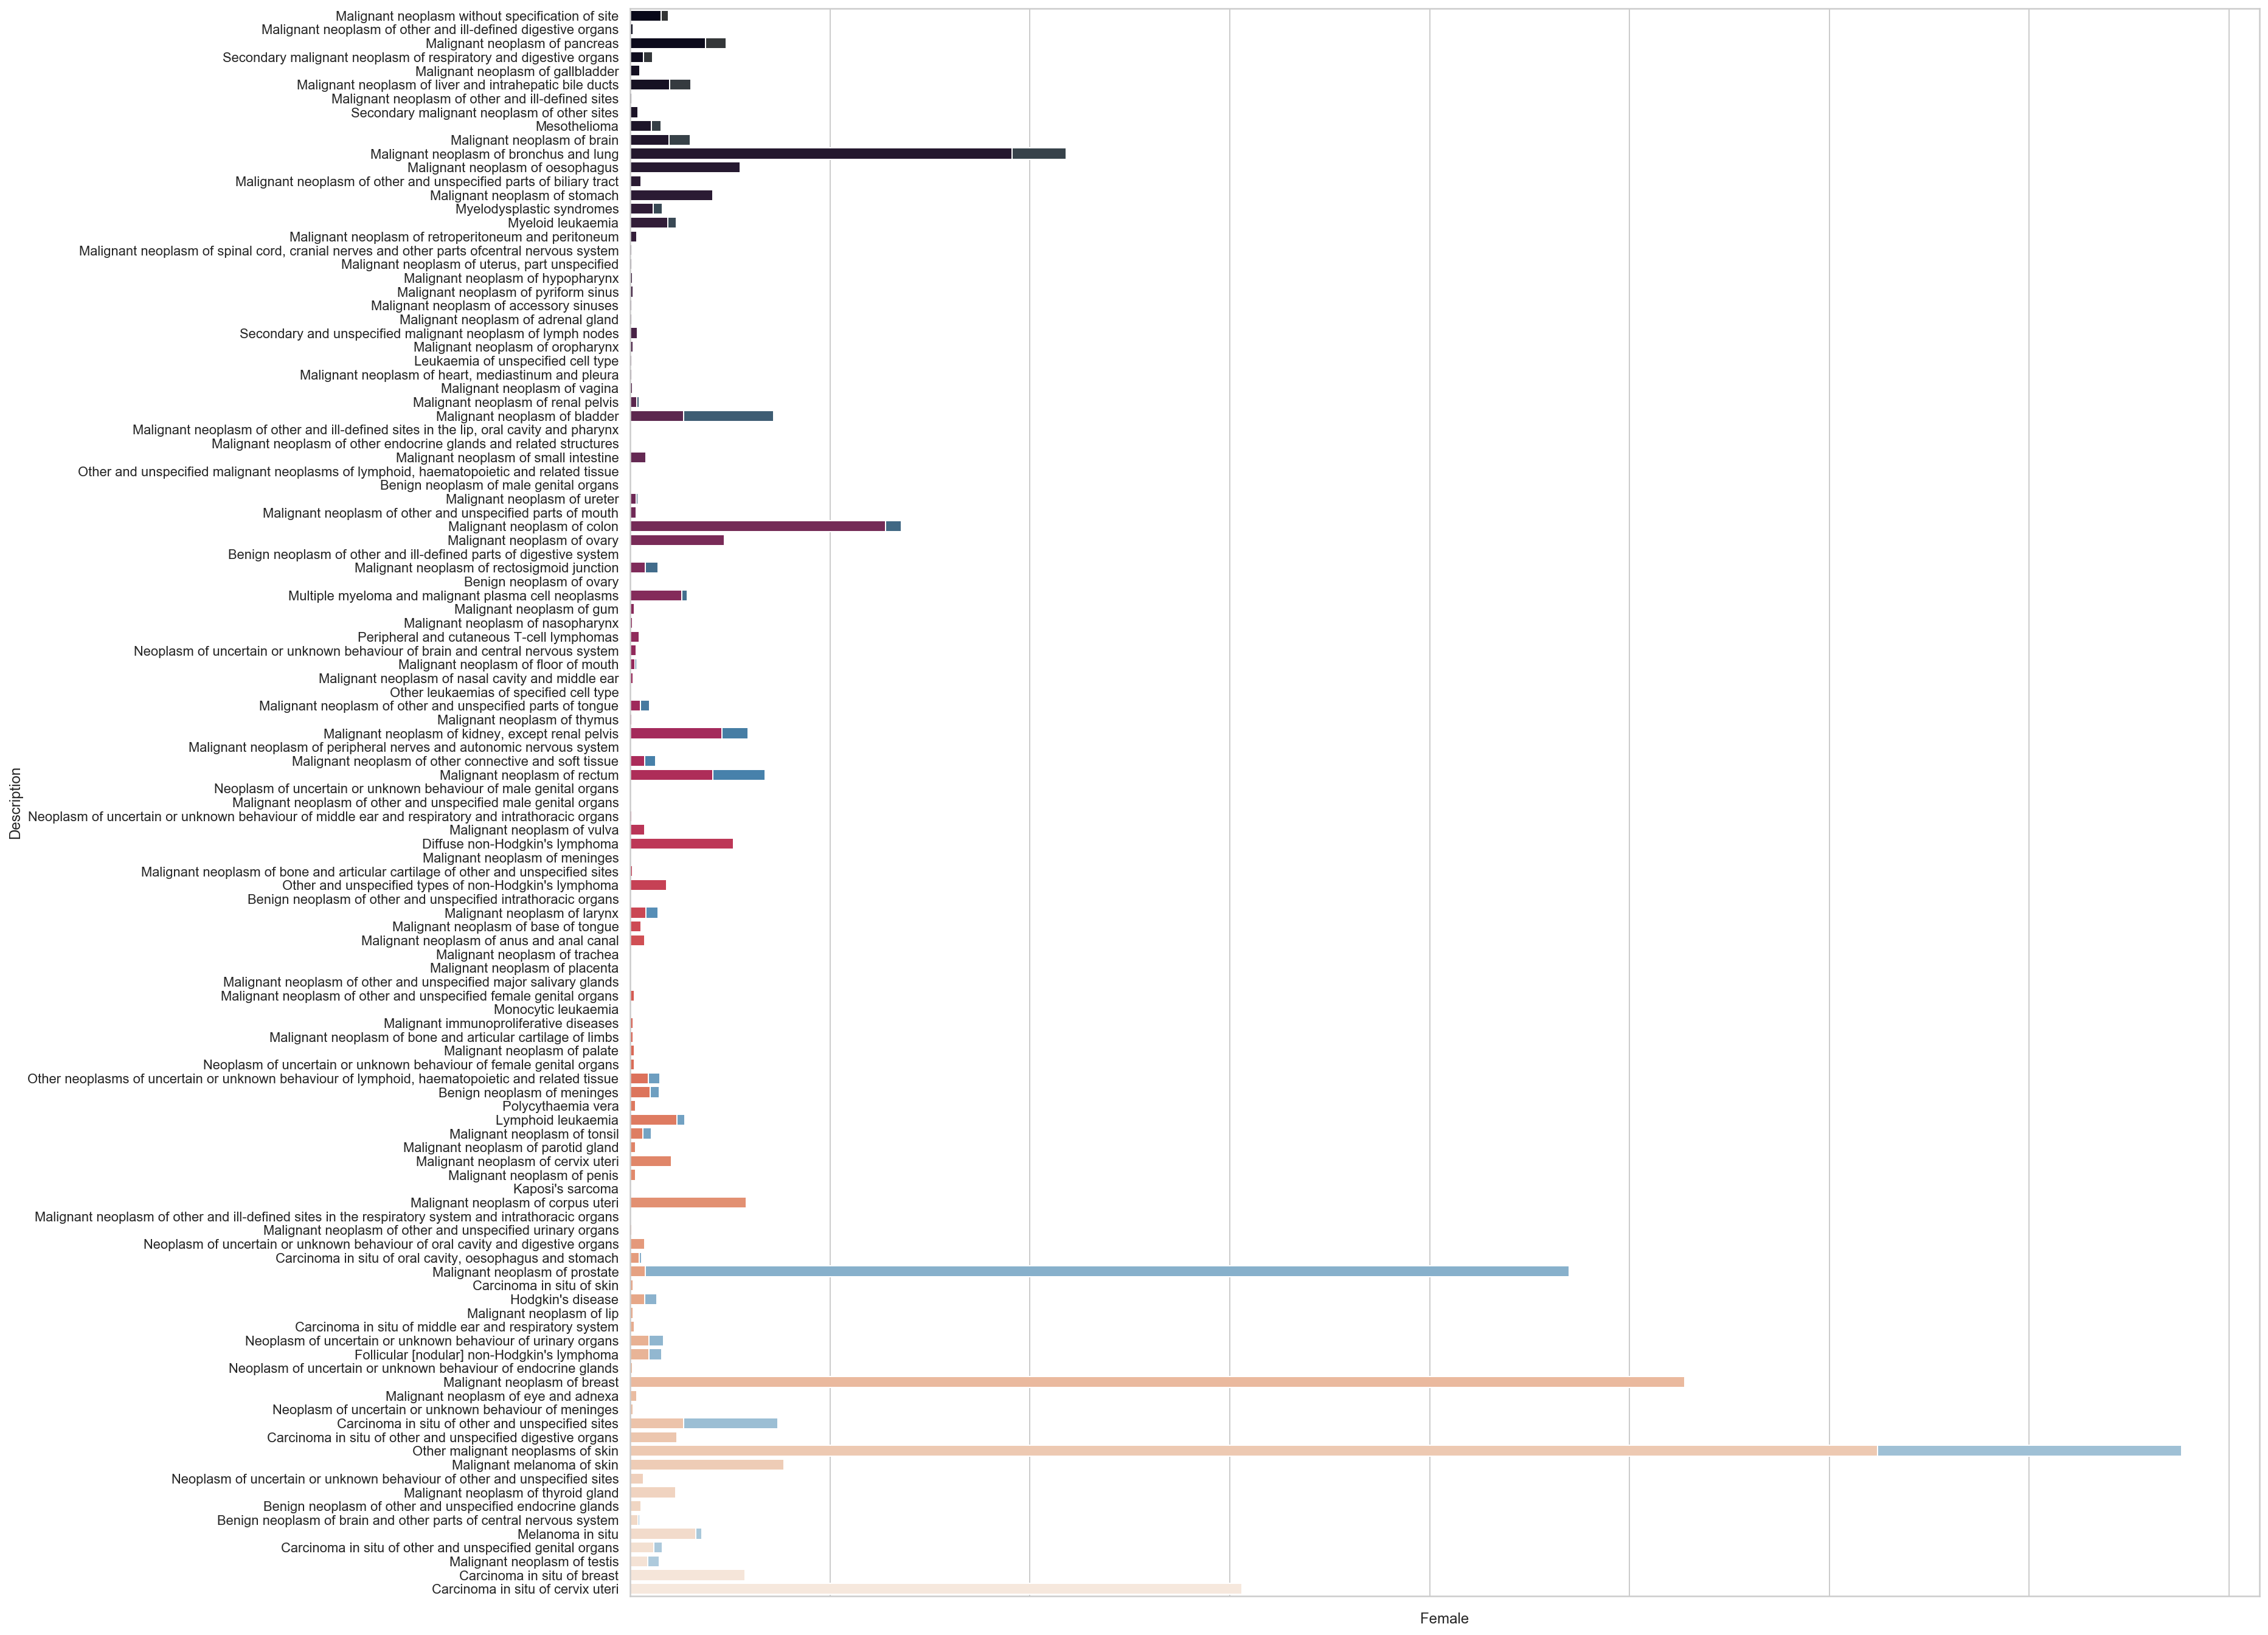

In [157]:
f2, axes2 = plt.subplots(1, 1, figsize=(24, 24), dpi=144, sharey=True)
types_of_neoplasms_by_sex = sns.barplot(data=types_of_cancer_3CHAR.sort_values('Death Rate', ascending=False), x='Male', y='Description', ax=axes2, palette='Blues_d')
types_of_neoplasms_by_sex = sns.barplot(data=types_of_cancer_3CHAR.sort_values('Death Rate', ascending=False), x='Female', y='Description', ax=axes2, palette='rocket')
axes2.set_xticklabels(axes2.get_xticklabels(), rotation=90)
plt.show()

In [152]:
types_of_cancer_3CHAR

,Code,Description,Amount,Death Rate,Male,Female
0,C44,Other malignant neoplasms of skin,350130,0.080579,194112,156018
1,C50,Malignant neoplasm of breast,133907,0.090413,1961,131946
2,C61,Malignant neoplasm of prostate,119347,0.124201,117501,1846
3,C34,Malignant neoplasm of bronchus and lung,102350,0.633141,54565,47785
4,D06,Carcinoma in situ of cervix uteri,76678,0.001500,144,76534
5,C18,Malignant neoplasm of colon,65825,0.317357,33892,31933
6,C43,Malignant melanoma of skin,38155,0.080016,18906,19249
7,C20,Malignant neoplasm of rectum,27163,0.258845,16880,10283
8,C64,"Malignant neoplasm of kidney, except renal pelvis",26195,0.264096,14765,11430
9,D09,Carcinoma in situ of other and unspecified sites,25193,0.084230,18492,6701


#### 2.6.3 TNM Staging and death rates

In [ ]:
The TNM